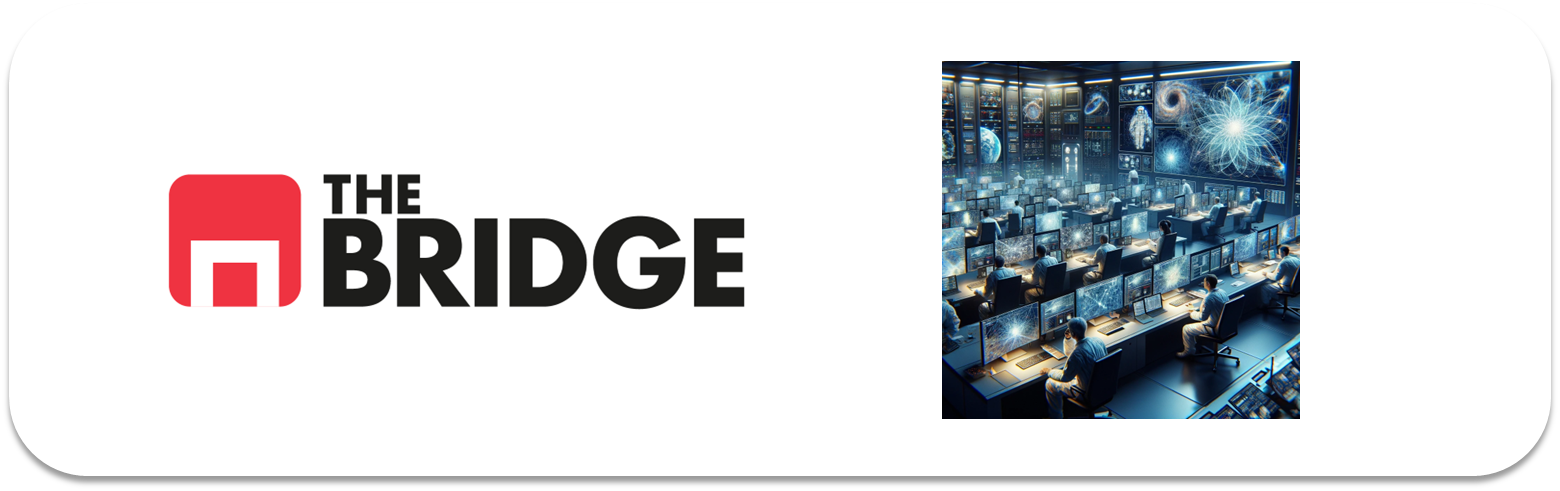

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,decode_predictions
from tensorflow.keras.preprocessing import image



# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
def show_images_batch(apples, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(apples) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, apple in enumerate(apples):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(apple)
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [4]:
# Procedemos a importar los datos desde la carpeta de apples, es necesario observar la estructura de la carpeta
TRAIN_PATH = r'C:\Users\julio\Desktop\The_Bridge\Temario\06. Deep Learning\Sprint 19 - DL aplicado a Imágenes\U2. Redes Convolucionales II. Transfer Learning y Fine-Tunning\Ejercicios\Ejercicios_Workout\data\apples\Train'
TEST_PATH = r'C:\Users\julio\Desktop\The_Bridge\Temario\06. Deep Learning\Sprint 19 - DL aplicado a Imágenes\U2. Redes Convolucionales II. Transfer Learning y Fine-Tunning\Ejercicios\Ejercicios_Workout\data\apples\Test'

# Cargamos cada imagen y su etiqueta
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_train.append(img)
        y_train.append(category)
# Transformamos a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# Verificamos que la carga de datos sea correcta
print(X_train.shape)
print(y_train.shape)
# Cargamos los datos de test
X_test = []
y_test = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(category)

# Transformamos a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
# Verificamos que la carga de datos sea correcta
print(X_test.shape)
print(y_test.shape)

(6404, 32, 32, 3)
(6404,)
(2134, 32, 32, 3)
(2134,)


In [5]:
# Cargamos los datos de test
X_test_224 = []
y_test_224 = []

for category in os.listdir(TEST_PATH):
    for file in os.listdir(os.path.join(TEST_PATH, category)):
        img = plt.imread(os.path.join(TEST_PATH, category, file))
        img = cv2.resize(img, (224, 224))
        X_test_224.append(img)
        y_test_224.append(category)

# Transformamos a numpy arrays
X_test_224 = np.array(X_test_224)
y_test_224 = np.array(y_test_224)

Text(0.5, 1.0, 'Braeburn')

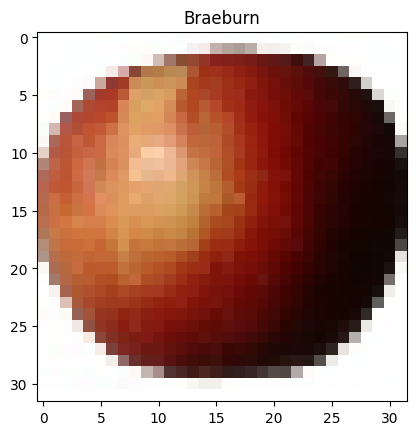

In [6]:
plt.imshow(X_train[0])
plt.title(y_train[0])

Text(0.5, 1.0, 'Braeburn')

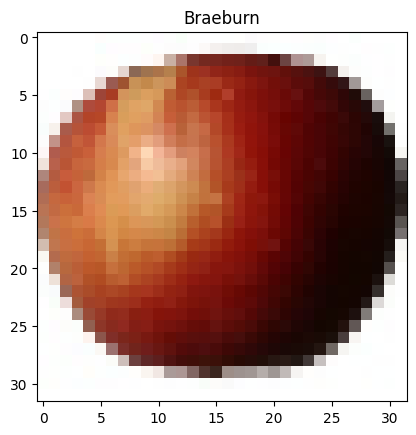

In [7]:
# Veamos una imagen de test
plt.imshow(X_test[0])
plt.title(y_test[0])

In [8]:
# Escalamos las imágenes
X_train = X_train / 255
X_test = X_test / 255

In [9]:
# Barajamos los datos, nos interesa hacerlo con train puesto que son a partir de los cuales aprende el modelo
X_train_s, y_train_s = shuffle(X_train, y_train, random_state=42)

In [10]:
# Mapeamos las categorías a números
categorias = np.unique(y_train)
n_categorias = len(categorias)

mapping = {cat: i for i, cat in enumerate(categorias)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}

In [ ]:
# Observamos el mapeo
mapping

In [11]:
inverse_mapping

{0: 'Braeburn',
 1: 'CrimsonSnow',
 2: 'Golden1',
 3: 'Golden2',
 4: 'Golden3',
 5: 'GrannySmith',
 6: 'PinkLady',
 7: 'Red1',
 8: 'Red2',
 9: 'Red3',
 10: 'RedDelicious',
 11: 'RedYellow1',
 12: 'RedYellow2'}

In [12]:
# Mapeamos las etiquetas
y_train_num = np.array([mapping[cat] for cat in y_train_s])
y_test_num = np.array([mapping[cat] for cat in y_test])

Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

In [13]:
base_model = ResNet50V2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))


In [14]:
seleccion = np.random.randint(0,len(X_test_224),20)
predictions = base_model.predict(X_test_224[seleccion])

1/1 [==============================] - 1s 1s/step


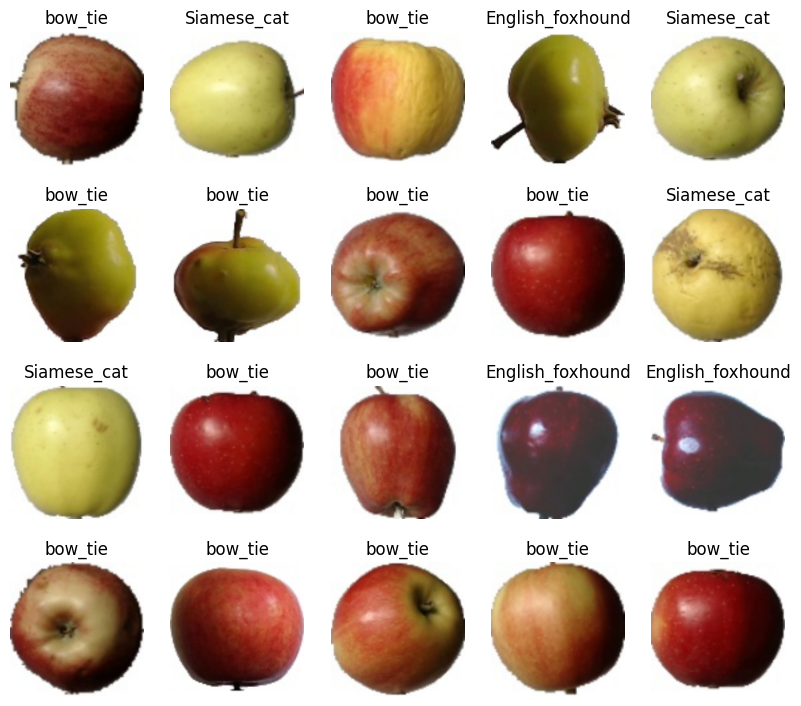

In [15]:
clase = [decodificado[0][1] for decodificado in decode_predictions(predictions)]
show_images_batch(X_test_224[seleccion], names = clase)

Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [16]:
# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 256 neuronas
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    # Capa densa con 512 neuronas
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

94668760/94668760 [==============================] - 24s 0us/step

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                           

In [17]:
# Entrenamos el modelo una sola vez
from time import time
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = 32,
                    validation_split=0.2,
                    epochs=1,)
print(time() - t_zero)



161/161 [==============================] - 33s 184ms/step - loss: 1.2955 - acc: 0.5952 - val_loss: 0.2962 - val_acc: 0.9133
33.026406049728394


In [18]:
# Entrenamos el modelo completo
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = 32,
                    validation_split=0.2,
                    epochs=16,
                   callbacks=[EarlyStopping(patience= 8, restore_best_weights= True)])

Epoch 1/16
161/161 [==============================] - 34s 191ms/step - loss: 1.2949 - acc: 0.5979 - val_loss: 0.3590 - val_acc: 0.8837
Epoch 2/16
161/161 [==============================] - 31s 192ms/step - loss: 0.4342 - acc: 0.8505 - val_loss: 0.1220 - val_acc: 0.9735
Epoch 3/16
161/161 [==============================] - 29s 184ms/step - loss: 0.2516 - acc: 0.9145 - val_loss: 0.0547 - val_acc: 0.9859
Epoch 4/16
161/161 [==============================] - 22s 138ms/step - loss: 0.1887 - acc: 0.9364 - val_loss: 0.0317 - val_acc: 0.9945
Epoch 5/16
161/161 [==============================] - 28s 176ms/step - loss: 0.1460 - acc: 0.9512 - val_loss: 0.0416 - val_acc: 0.9867
Epoch 6/16
161/161 [==============================] - 21s 133ms/step - loss: 0.1501 - acc: 0.9463 - val_loss: 0.0228 - val_acc: 0.9961
Epoch 7/16
161/161 [==============================] - 28s 174ms/step - loss: 0.1300 - acc: 0.9559 - val_loss: 0.0140 - val_acc: 0.9992
Epoch 8/16
161/161 [==============================] - 2

In [19]:
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 12s 178ms/step - loss: 0.7394 - acc: 0.8332


[0.7394205331802368, 0.8331771492958069]

In [20]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 [==============================] - 13s 179ms/step
              precision    recall  f1-score   support

    Braeburn       0.68      0.76      0.72       164
 CrimsonSnow       0.79      0.87      0.83       148
     Golden1       0.79      0.97      0.87       160
     Golden2       1.00      0.84      0.91       164
     Golden3       0.64      0.52      0.57       161
 GrannySmith       0.99      0.84      0.90       164
    PinkLady       0.76      0.82      0.79       152
        Red1       0.96      0.83      0.89       164
        Red2       0.54      0.68      0.60       164
        Red3       0.98      0.68      0.80       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       0.84      1.00      0.91       164
  RedYellow2       1.00      0.96      0.98       219

    accuracy                           0.83      2134
   macro avg       0.84      0.83      0.83      2134
weighted avg       0.85      0.83      0.83      2134



In [21]:
report_dict_1 = classification_report(y_test, y_pred,output_dict=True)
# Convert the dictionary to a DataFrame
report_df_1 = pd.DataFrame(report_dict_1).transpose()
report_df_1

,precision,recall,f1-score,support
Braeburn,0.683060,0.762195,0.720461,164.000000
CrimsonSnow,0.791411,0.871622,0.829582,148.000000
Golden1,0.786802,0.968750,0.868347,160.000000
Golden2,1.000000,0.841463,0.913907,164.000000
Golden3,0.636364,0.521739,0.573379,161.000000
GrannySmith,0.985612,0.835366,0.904290,164.000000
PinkLady,0.760736,0.815789,0.787302,152.000000
Red1,0.964539,0.829268,0.891803,164.000000
Red2,0.538835,0.676829,0.600000,164.000000
Red3,0.980000,0.680556,0.803279,144.000000


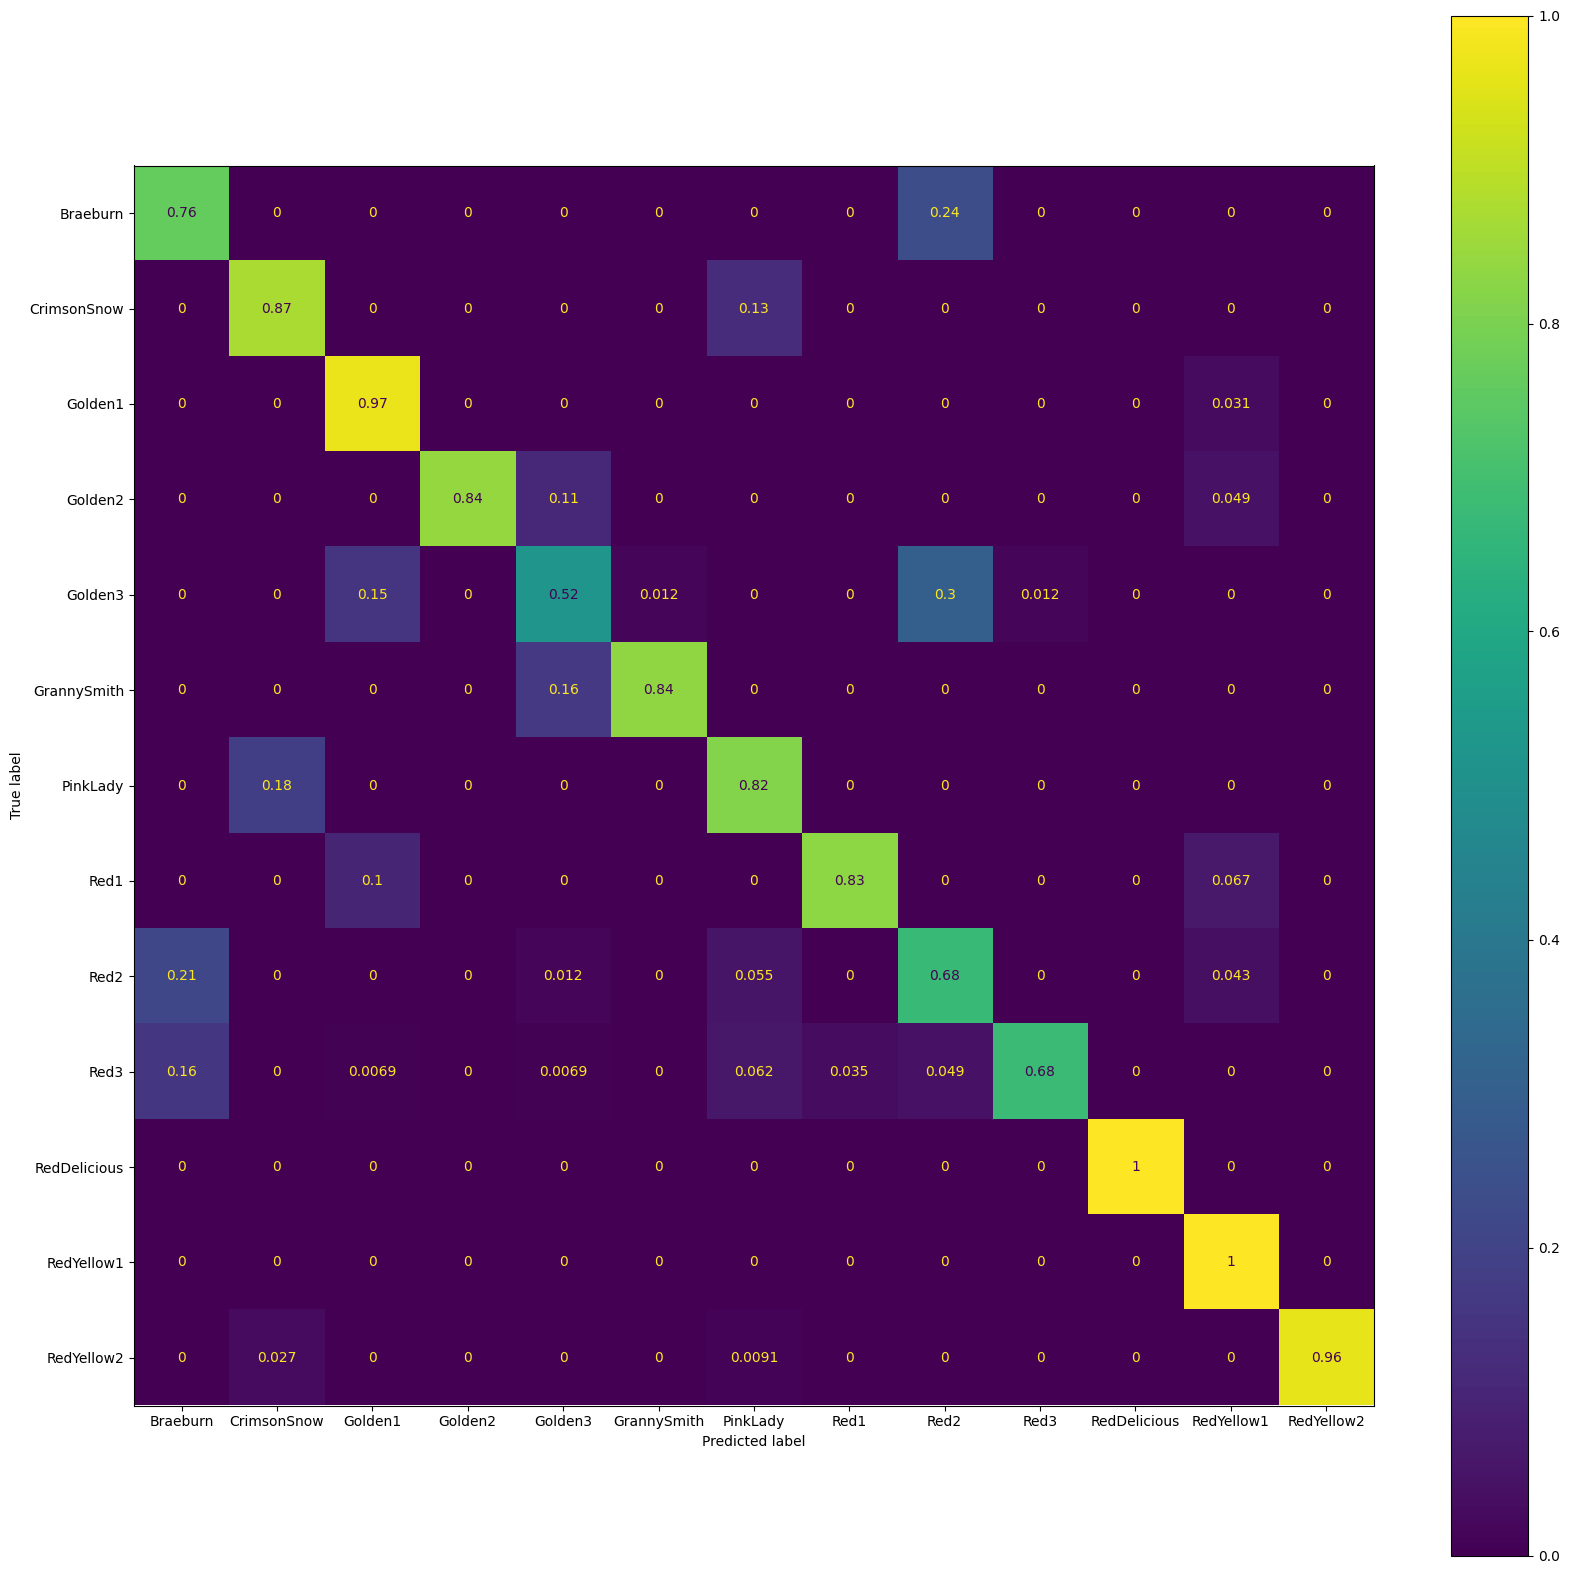

In [22]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

In [23]:
len(base_model.layers) 
#pongo el 50%

190

In [24]:
# Congelamos sus capas
for layer in base_model.layers[-95:]:
    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = layers.Flatten()(base_model.output)
    
    # Capa densa con 256 neuronas
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    # Capa densa con 512 neuronas
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(rate = 0.5)(x)
    # Capa final de salida con 13 neuronas y activación softmax
    x = layers.Dense(13, activation='softmax')(x)
    
    model = Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

In [25]:
# Entrenamos el modelo completo
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_num,
                    batch_size = 32,
                    validation_split=0.2,
                    epochs=16,
                   callbacks=[EarlyStopping(patience= 8, restore_best_weights= True)])

Epoch 1/16
161/161 [==============================] - 33s 189ms/step - loss: 1.2945 - acc: 0.5797 - val_loss: 0.2910 - val_acc: 0.9266
Epoch 2/16
161/161 [==============================] - 29s 183ms/step - loss: 0.4358 - acc: 0.8489 - val_loss: 0.1269 - val_acc: 0.9625
Epoch 3/16
161/161 [==============================] - 31s 191ms/step - loss: 0.2383 - acc: 0.9176 - val_loss: 0.0480 - val_acc: 0.9930
Epoch 4/16
161/161 [==============================] - 23s 142ms/step - loss: 0.1876 - acc: 0.9332 - val_loss: 0.0486 - val_acc: 0.9875
Epoch 5/16
161/161 [==============================] - 30s 189ms/step - loss: 0.1840 - acc: 0.9354 - val_loss: 0.0217 - val_acc: 0.9953
Epoch 6/16
161/161 [==============================] - 30s 186ms/step - loss: 0.1287 - acc: 0.9559 - val_loss: 0.0240 - val_acc: 0.9945
Epoch 7/16
161/161 [==============================] - 26s 164ms/step - loss: 0.1262 - acc: 0.9569 - val_loss: 0.0239 - val_acc: 0.9938
Epoch 8/16
161/161 [==============================] - 2

In [26]:
model.evaluate(X_test, y_test_num)

67/67 [==============================] - 5s 75ms/step - loss: 0.6940 - acc: 0.8351


[0.6940135359764099, 0.8350515365600586]

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [inverse_mapping[np.argmax(prediccion)] for prediccion in model.predict(X_test)]
print(classification_report(y_test, y_pred))

67/67 [==============================] - 13s 183ms/step
              precision    recall  f1-score   support

    Braeburn       0.67      0.81      0.73       164
 CrimsonSnow       1.00      0.87      0.93       148
     Golden1       0.87      0.99      0.92       160
     Golden2       0.98      0.71      0.83       164
     Golden3       0.56      0.71      0.63       161
 GrannySmith       0.98      0.80      0.88       164
    PinkLady       0.82      0.87      0.85       152
        Red1       0.89      0.87      0.88       164
        Red2       0.67      0.70      0.69       164
        Red3       0.74      0.42      0.54       144
RedDelicious       1.00      1.00      1.00       166
  RedYellow1       0.78      1.00      0.88       164
  RedYellow2       1.00      1.00      1.00       219

    accuracy                           0.84      2134
   macro avg       0.84      0.83      0.83      2134
weighted avg       0.85      0.84      0.83      2134



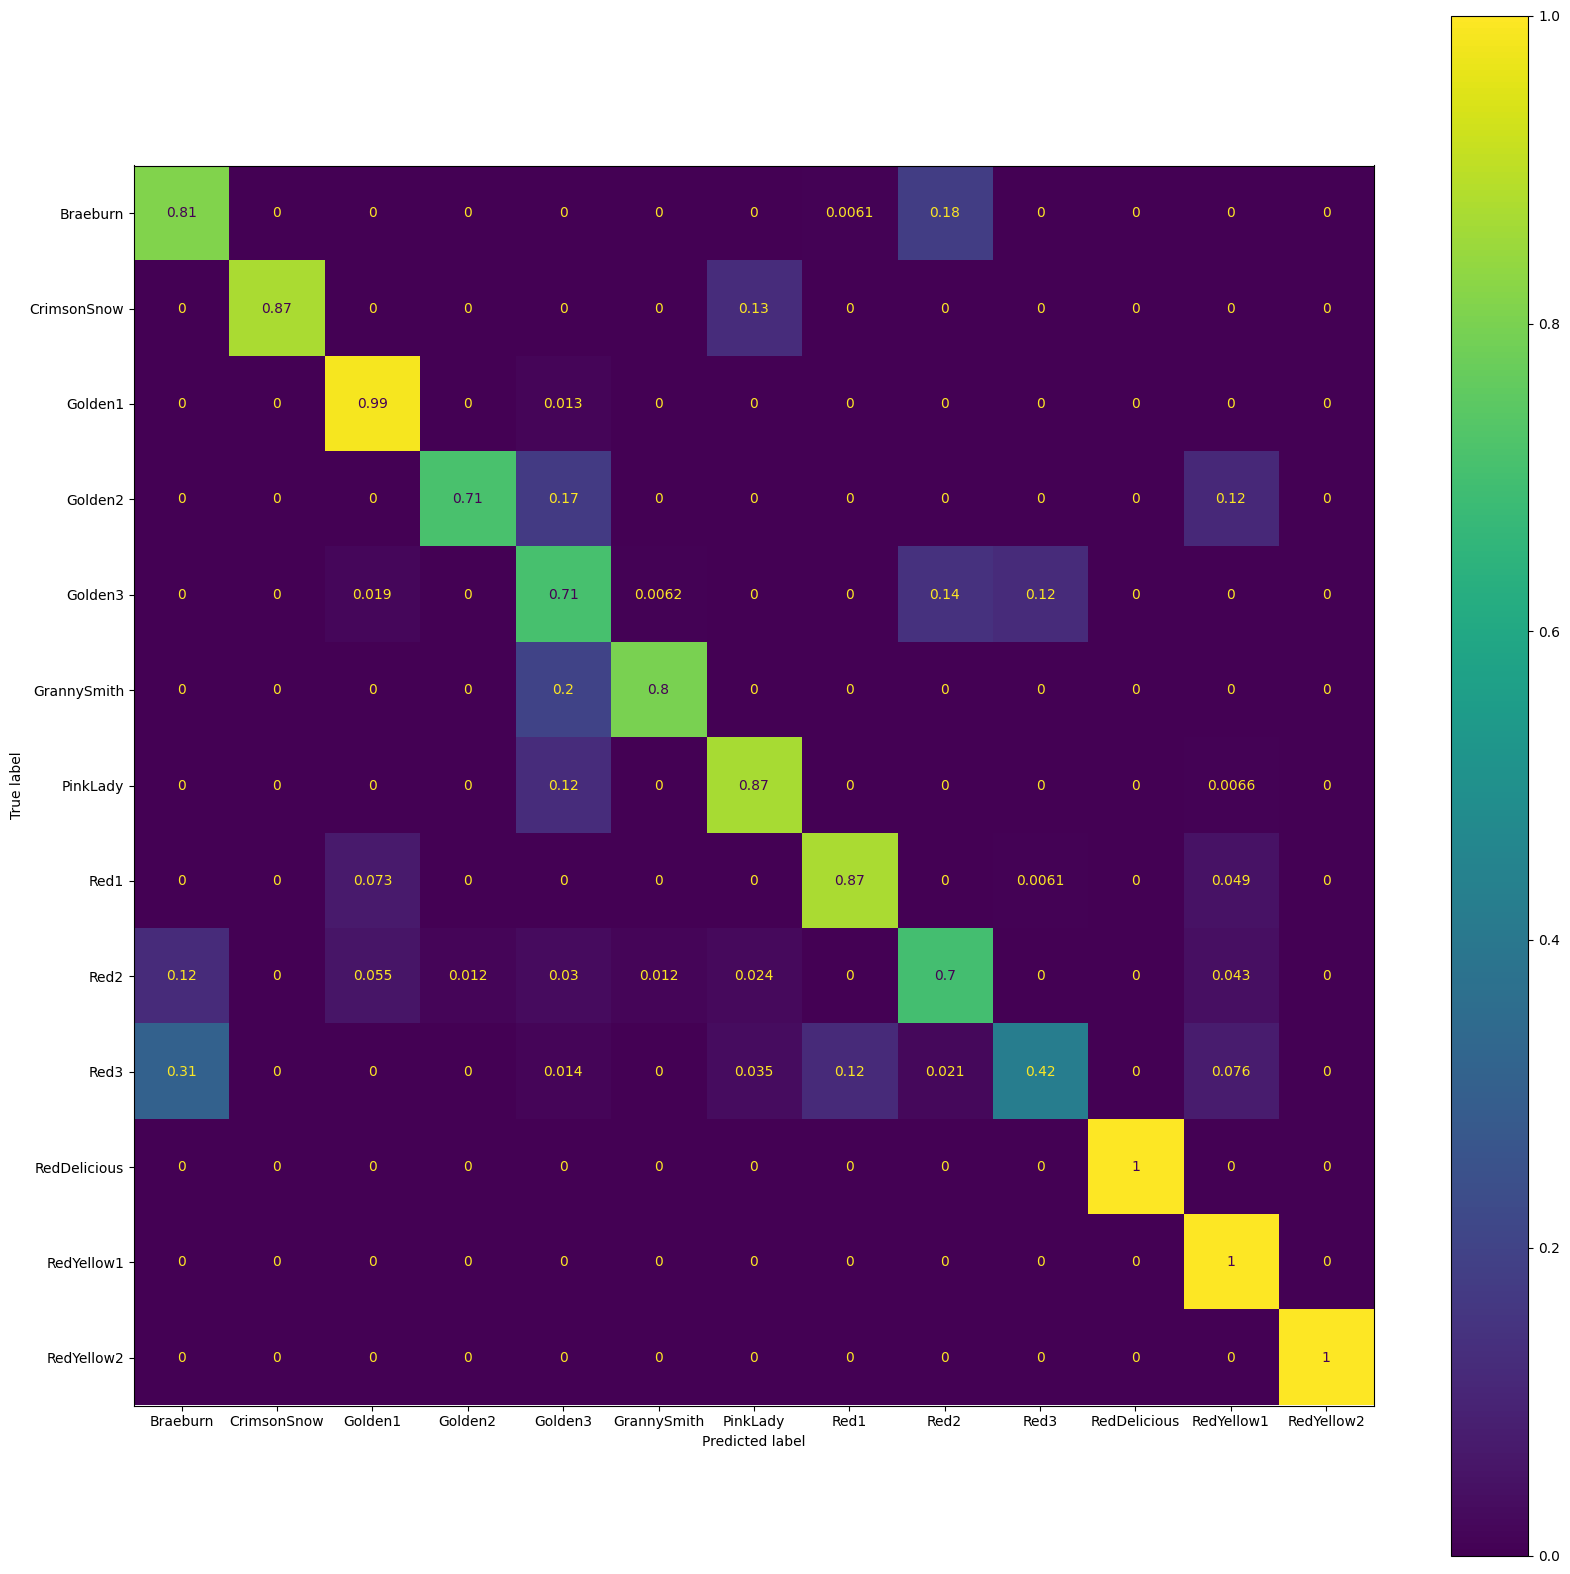

In [28]:
fig,axs = plt.subplots(1,1,figsize = (20,20))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true", ax = axs)

Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.


In [29]:
report_dict_2 = classification_report(y_test, y_pred,output_dict=True)
# Convert the dictionary to a DataFrame
report_df_2 = pd.DataFrame(report_dict_1).transpose()
report_df_2

,precision,recall,f1-score,support
Braeburn,0.683060,0.762195,0.720461,164.000000
CrimsonSnow,0.791411,0.871622,0.829582,148.000000
Golden1,0.786802,0.968750,0.868347,160.000000
Golden2,1.000000,0.841463,0.913907,164.000000
Golden3,0.636364,0.521739,0.573379,161.000000
GrannySmith,0.985612,0.835366,0.904290,164.000000
PinkLady,0.760736,0.815789,0.787302,152.000000
Red1,0.964539,0.829268,0.891803,164.000000
Red2,0.538835,0.676829,0.600000,164.000000
Red3,0.980000,0.680556,0.803279,144.000000
